##  E-commerce проект продажи интернет магазина
Проект от https://karpov.courses/analytics

Проджект попросил проанализировать процесс совершение покупки и ответить на следующие вопросы:
1. Сколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
5. В период с января по декабрь выяви когорту с самым высоким retention на 1й месяц.
6. Провести качественный анализ и построить RFM-сегментацию


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
import json

%matplotlib inline

In [2]:
prefecs = 'https://getfile.dokpub.com/yandex/get/'
file_1_customers = 'http://disk.yandex.ru/d/QXrVDUoQvFhIcg'
file_2_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
file_3_order_item = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

df_customers = pd.read_csv(prefecs + file_1_customers)
df_orders = pd.read_csv(
    prefecs + file_2_orders,
    parse_dates=[
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
)
df_order_item = pd.read_csv(
    prefecs + file_3_order_item,
    parse_dates=['shipping_limit_date']
)

In [3]:
# Настроим отображение графиков
sns.set(
    font_scale=1,
    style='whitegrid',
    rc={"figure.figsize": (18, 7)})

### Изучим данные и проверим достоверность данных


In [4]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
df_customers.dtypes # Проверим тип данных

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
df_customers.shape[0] # Кол строк

99441

In [7]:
# Проверим null
df_customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
df_customers.nunique() # Как видим одному пользователю может принадлежать несколько customer_id

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [9]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [10]:
df_orders.dtypes # Проверим тип данных

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [11]:
df_orders.order_purchase_timestamp.min() # Первый заказ

Timestamp('2016-09-04 21:15:19')

In [12]:
df_orders.order_purchase_timestamp.max() # Заказ 

Timestamp('2018-10-17 17:30:18')

In [13]:
# Данные за дней:
(df_orders.order_purchase_timestamp.max() - df_orders.order_purchase_timestamp.min()).days

772

In [14]:
df_orders.shape[0] # Кол строк

99441

In [15]:
# Проверим null
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [16]:
df_orders.groupby('order_status').size() # Посмотрим кол заказов с различными статусами, как видим есть отмененные и недоступные

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
dtype: int64

In [17]:
df_order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [18]:
df_order_item.dtypes # Проверим тип данных

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [19]:
df_order_item.shape[0] # Кол строк

112650

In [20]:
df_order_item.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [21]:
df_order_item.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

### Сколько у нас пользователей, которые совершили покупку только один раз?

In [22]:
# Определимся кто такой покупатель:
# Это точно тот кто оплатил товар (order_approved_at != NaN) и у него статус 
# не canceled, так как отмена заказа не считается покупкой.

# Найдем количество заказов каждого пользователя. 
# Посмотрим сколько входят пользователей в группу с 1 заказом и в группу > 1.
unique_id_by_orders = (df_customers.merge(df_orders, on='customer_id')
                       .loc[(df_orders['order_approved_at'].notnull()) & 
                            (df_orders['order_status'] != 'canceled')]
                       .groupby('customer_unique_id', as_index=False)
                       .agg({'customer_id': 'count'})
                       .rename(columns={'customer_id': 'count_orders'}))

# Группа с 1 заказом:
one_order = unique_id_by_orders.loc[unique_id_by_orders['count_orders'] == 1]['customer_unique_id'].count()

# В процентах от всех пользователей:
total_customers = unique_id_by_orders['customer_unique_id'].count()
one_order_percentage = round((one_order / total_customers) * 100, 2)

print(f'Только 1 раз совершили покупку {one_order} пользователей, '
      f'что составляет {one_order_percentage}%, от всех покупателей')

Только 1 раз совершили покупку 92542 пользователей, что составляет 96.9%, от всех покупателей


In [23]:
# А сколько у нас пользователей, которые делают больше 1 заказа:
more_one_order = (unique_id_by_orders
                 .loc[unique_id_by_orders['count_orders'] > 1]
                 ['customer_unique_id']
                 .count())

# В процентах от всех пользователей:
total_customers = unique_id_by_orders['customer_unique_id'].count()
more_one_order_percentage = round((more_one_order / total_customers) * 100, 2)

print(f'Больше 1 раза совершили покупку {more_one_order} пользователей, '
      f'что составляет {more_one_order_percentage}%, от всех покупателей')

Больше 1 раза совершили покупку 2957 пользователей, что составляет 3.1%, от всех покупателей


### Сколько заказов в месяц в среднем не доставляется по разным причинам?

In [24]:
# Создадим отдельный столбец с месяцем
# Месяц в который не доставили, будем считать тот в который должны были привезти товар.
df_orders['estimated_delivery_month'] = df_orders['order_estimated_delivery_date'].dt.strftime('%m')
df_orders['estimated_delivery_mon_year'] = df_orders['order_estimated_delivery_date'].dt.strftime('%Y-%m')

# Товары которые не доставили, это unavailable и canceled. Так как другие либо доставлены либо в пути
canceled_and_unavailable_orders = (
    df_orders.query('order_status == "unavailable" or order_status == "canceled"') \
    .groupby(['estimated_delivery_mon_year','estimated_delivery_month', 'order_status'], as_index=False) \
    .agg(count_order_id = ('order_id', 'count'))
)

# Всего недоставили товаров
all_canceled_orders = canceled_and_unavailable_orders['count_order_id'].sum()
# Процент от всех заказов
all_canceled_orders_percentage = round(all_canceled_orders / df_orders['order_id'].nunique() * 100, 2)
# Заказов в среднем не смогли доставить
all_mean_canceled_orders = (
    canceled_and_unavailable_orders.groupby('estimated_delivery_mon_year', as_index=False) \
    .agg({'count_order_id': 'sum'})['count_order_id'].mean().astype(int)
)

print(f'Не смогли доставить {all_canceled_orders} заказов, '
      f'что составляет {all_canceled_orders_percentage}%, от всех заказов. '
      f'В среднем в месяц не доставляют {all_mean_canceled_orders} закзаов')

# Отмененные заказы
canceled_orders = canceled_and_unavailable_orders.query('order_status == "canceled"')['count_order_id'].sum()
# Процент отмененных заказов от всех заказов
canceled_orders_percentage = round(canceled_orders / df_orders['order_id'].nunique() * 100, 2)
# Заказов в среднем не смогли доставить
mean_canceled_orders = int(canceled_and_unavailable_orders.query('order_status == "canceled"')['count_order_id'].mean())

print(f'Из которых отменили заказ {canceled_orders} заказов, '
      f'что составляет {canceled_orders_percentage}%, от всех заказов. '
      f'В среднем в месяц не доставляют {mean_canceled_orders} закзаов')

# Не смогли доставить заказы
unavailable_orders = canceled_and_unavailable_orders.query('order_status == "unavailable"')['count_order_id'].sum()
# Процент заказов, которые не смогли доставить от всех заказов
unavailable_orders_percentage = round(unavailable_orders / df_orders['order_id'].nunique() * 100, 2)
# Заказов в среднем не смогли доставить
mean_unavailable_orders = int(canceled_and_unavailable_orders.query('order_status == "canceled"')['count_order_id'].mean())

print(f'и не смогли доставить {unavailable_orders} заказов, '
      f'что составляет {unavailable_orders_percentage}%, от всех заказов. '
      f'В среднем в месяц не доставляют {mean_unavailable_orders} закзаов')

Не смогли доставить 1234 заказов, что составляет 1.24%, от всех заказов. В среднем в месяц не доставляют 47 закзаов
Из которых отменили заказ 625 заказов, что составляет 0.63%, от всех заказов. В среднем в месяц не доставляют 24 закзаов
и не смогли доставить 609 заказов, что составляет 0.61%, от всех заказов. В среднем в месяц не доставляют 24 закзаов


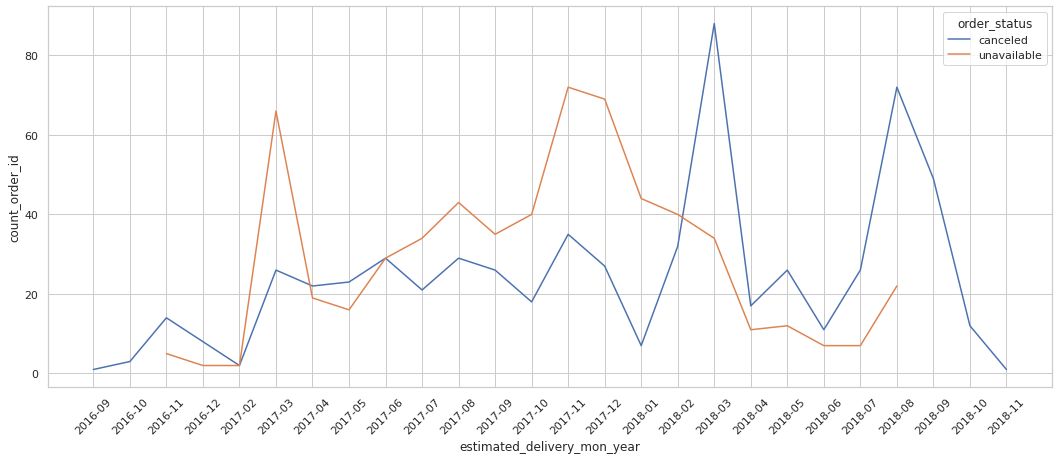

In [25]:
# Посмотрим распределение по месяцам 
sns.lineplot(data=canceled_and_unavailable_orders, x ='estimated_delivery_mon_year', y ='count_order_id', hue ='order_status')
plt.xticks(rotation=45)
plt.show()

### По каждому товару определить, в какой день недели чаще всего покупается

In [26]:
# Будем считать только те заказы которые подтвердили order_approved_at != 0 
# и будем выводить день недели когда задак был создан order_purchase_timestamp
df_orders['day_of_the_week_order'] = df_orders.order_purchase_timestamp.dt.day_name() # день недели заказа
df_orders_and_item = df_orders.merge(df_order_item, on = 'order_id') # объединим таблицы заказов и товаров

# Уберем order_approved_at = 0 и сгрупируем по дням и товарам
count_purchase_by_day = (
    df_orders_and_item.loc[df_orders_and_item.order_approved_at.notnull()].groupby(['product_id', "day_of_the_week_order"], as_index = False) \
    .agg(count_purchase = ('order_id', 'count'))
)

# Найдем день в который чаще всего покупают товары
day_of_the_week_purchase_product_id = (
    count_purchase_by_day.groupby(['product_id'], as_index=False) \
    .apply(lambda group: group.loc[group['count_purchase'].idxmax()]) \
    .reset_index(drop=True) \
    .sort_values('count_purchase', ascending =False)
)

day_of_the_week_purchase_product_id.head()

,product_id,day_of_the_week_order,count_purchase
8612,422879e10f46682990de24d770e7f83d,Wednesday,93
19740,99a4788cb24856965c36a24e339b6058,Monday,92
22110,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
10865,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
7363,389d119b48cf3043d311335e499d9c6b,Thursday,67


### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
(изменить месяца расчета)

In [27]:
# Так как количество дней в месяце мб нечетное, расчитаем сколько недель в месяце
# Добавим столбец количество дней в месяце, месяцы и месяцы с годом
df_orders['weeks_in_month'] = df_orders.order_purchase_timestamp.apply(lambda date: date.days_in_month/7).round(2)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].dt.strftime('%m')
df_orders['order_purchase_mon_year'] = df_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_delivery_month,estimated_delivery_mon_year,day_of_the_week_order,weeks_in_month,order_purchase_month,order_purchase_mon_year
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,10,2017-10,Monday,4.43,10,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,08,2018-08,Tuesday,4.43,07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,09,2018-09,Wednesday,4.43,08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,12,2017-12,Saturday,4.29,11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,02,2018-02,Tuesday,4.00,02,2018-02


In [28]:
# Расчитаем кол. покупок заказов в месяц. Исключаем пользователей без оплат и тех кто имеет статус canceled
order_and_costomer = df_customers.merge(df_orders, on = 'customer_id') \
    .loc[(df_orders.order_approved_at.notnull()) & (df_orders.order_status != "canceled")]

count_purchase_year = order_and_costomer.groupby(['customer_unique_id', 'order_purchase_mon_year', 'order_purchase_month', 'weeks_in_month'], as_index=False) \
    .agg(count_purchase = ('order_id', 'count'))
# Создадим отдельный столбец со средним кол. покупок в неделю.
count_purchase_year['mean_purchase_week'] = round(count_purchase_year['count_purchase']/ count_purchase_year["weeks_in_month"], 2)
# Уберем года и сгруппируем по месяцам
count_purchase_year.groupby(['customer_unique_id', 'order_purchase_month'], as_index=False) \
    .agg({'mean_purchase_week': 'mean'}) \
    .sort_values('mean_purchase_week', ascending=False).head()

,customer_unique_id,order_purchase_month,mean_purchase_week
7286,12f5d6e1cbf93dafd9dcc19095df0b3d,01,1.35
68913,b4e4f24de1e8725b74e4a1f4975116ed,02,1.00
61766,a239b8e2fbce33780f1f1912e2ee5275,02,1.00
23765,3e43e6105506432c953e165fb2acf44c,02,1.00
14396,25a560b9a6006157838aab1bdbd68624,04,0.93


### В период с января по декабрь выяви когорту с самым высоким retention на 1й месяц.

In [29]:
# Создадим столбец с датой 1 покупки и расчитаем месяц для ретеншена
order_and_costomer['first_bought'] = order_and_costomer.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
order_and_costomer['N_month_retention'] = (
    (order_and_costomer['order_purchase_timestamp'].dt.year - order_and_costomer['first_bought'].dt.year) * 12 + 
    (order_and_costomer['order_purchase_timestamp'].dt.month - order_and_costomer['first_bought'].dt.month) + 0
)

# Посчитаем сколько покупок совершали пользователи по годам и месяцам 
cogorta_by_year = order_and_costomer.groupby(['first_bought', 'N_month_retention'], as_index=False) \
    .agg(count_in_cogort = ('customer_unique_id', 'nunique'))
cogorta_by_year['month'] = cogorta_by_year.first_bought.dt.strftime('%m')
# Уберем год и сгрупируем по месяцу = когорты по месяцам
cogorta_by_month = cogorta_by_year.groupby(['month', 'N_month_retention'], as_index=False) \
    .agg({'count_in_cogort': 'sum'}) 
# Расчитаем ретеншен по месяцам
cogorta_by_month['count_month_0'] = cogorta_by_month.groupby('month').transform('max')['count_in_cogort']
cogorta_by_month['percent'] = round(cogorta_by_month.count_in_cogort / cogorta_by_month.count_month_0 * 100, 2)
# Мах ретеншен 1 дня:
cogorta_by_month.loc[cogorta_by_month.N_month_retention == 1].sort_values('percent', ascending =False).head(1)

,month,N_month_retention,count_in_cogort,count_month_0,percent
130,09,1,27,4110,0.66


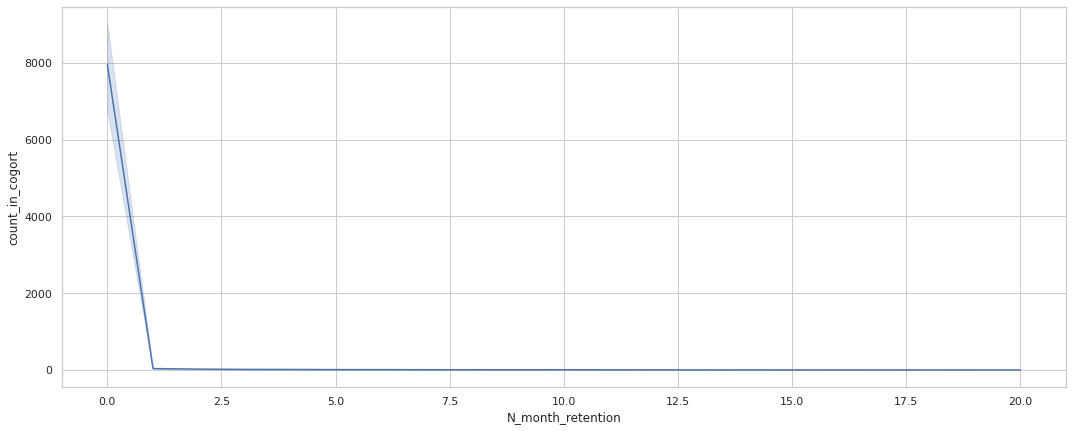

In [30]:
sns.lineplot(data = cogorta_by_month, x='N_month_retention', y ='count_in_cogort')

### Провести качественный анализ и построить RFM-сегментацию

In [31]:
# Максимальная и минимальная дата
print('Orders from {} to {}'.format(order_and_costomer['order_purchase_timestamp'].min(),
                                    order_and_costomer['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


In [32]:
# Создадим группу recency, используем данные из прошлого задания. Из выборки убираем заказы с отказами и заказы без оплат
order_and_costomer['last_order'] = (order_and_costomer.order_purchase_timestamp.max() - order_and_costomer.order_purchase_timestamp).dt.days

In [33]:
# Посчитаем выручку с заказа.
df_order_item['sum_price'] = round(df_order_item.price * df_order_item.freight_value, 2)

order_sum_price = df_order_item.groupby('order_id', as_index=False) \
    .agg({'sum_price' : 'sum'})

In [34]:
# Присоединим таблицу:
RFM = (
    order_and_costomer.merge(order_sum_price, on = 'order_id', how='left') \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'order_purchase_timestamp' : 'max','last_order' : 'min', 'order_id' : 'count', 'sum_price' : 'sum'}) \
    .rename(columns={'order_id' : 'frequency', 'last_order' : 'recency', 'sum_price' : 'monetary'})
)
RFM.head()

,customer_unique_id,order_purchase_timestamp,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,1,1558.80
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,1,156.68
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,1,1188.18
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,1,458.20
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,1,3040.20


In [35]:
# Разница между макс и мин: 
RFM['order_purchase_timestamp'].max() - RFM['order_purchase_timestamp'].min()

Timedelta('772 days 20:14:59')

In [36]:
print('Минимальное кол. заказов {}, Максимальное кол. заказов {}'.format(RFM['frequency'].min(), RFM['frequency'].max()))
print('Минимальная сумма заказа {}, Максимальная сумма заказа {}'.format(RFM['monetary'].min(), RFM['monetary'].max()))

Минимальное кол. заказов 1, Максимальное кол. заказов 17
Минимальная сумма заказа 0.0, Максимальная сумма заказа 1479562.34


In [37]:
# Посчитаем процентили:
quintiles = RFM[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles
# Как видим заказов у нас очень мало и frequency, все имеют одинаковую оценку. Чтобы увидеть разницу добавлю в ручную значения
# frequency = 5 если более 5 покупок
# recency = 4 если 4 заказа
# recency = 3 если 3 заказа
# recency = 2 если 2 заказа
# recency = 1 если 1 заказ

{'recency': {0.2: 142.0, 0.4: 227.0, 0.6: 317.0, 0.8: 433.0},
 'monetary': {0.2: 518.2980000000005, 0.4: 1047.4, 0.6: 1900.52, 0.8: 3872.59}}

In [38]:
# Проранжируем RFM:
def recency_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def frequency_score(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5 

def monetary_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5  

In [39]:
RFM['R'] = RFM['recency'].apply(lambda x: recency_score(x))
RFM['F'] = RFM['frequency'].apply(lambda x: frequency_score(x))
RFM['M'] = RFM['monetary'].apply(lambda x: monetary_score(x))
RFM['RFM'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)

In [40]:
# Классы:
# Нас интересуют 2 показателя: R (5-4 - купили недавно), 3 давно не покупали, 1-2 очень давно не покупали 
# F 1 - совершили разовую покупку, 2-5 - совершил несколько покупок
# M -  нас интересует, у нас не такая большая выборка, чтобы плодить классы. А частота покупок, обычно отражает и доход от клиента, проще будет выбирать конкретную группу по частоте и группу с monetary
segt_map = {
    r'[1-2][1]': 'hibernating', # Разовая покупка давно
    r'[1-2][2-5]': 'at_risk', # Давно не покупали, но раньше покупали часто
    r'31': 'about_to_sleep', # Давно не покупали, можем потерять
    r'3[2-5]': 'need_attention', # Клиенты, требующие внимания
    r'4[2-5]': 'loyal_customers', # Покупают на регулярной основе. Реагирует на рекламные акции. 
    r'[4-5]1': 'new_customers', # Купил недавно, 1 раз
    r'5[2-3]': 'potential_loyalists', # Недавние клиенты со средней частотой
    r'5[4-5]': 'champions' # Купили недавно, покупают часто и тратят много
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,customer_unique_id,order_purchase_timestamp,recency,frequency,monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,1,1558.80,4,1,3,413,new_customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,1,156.68,4,1,1,411,new_customers
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,1,1188.18,1,1,3,113,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,1,458.20,2,1,1,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,1,3040.20,2,1,4,214,hibernating


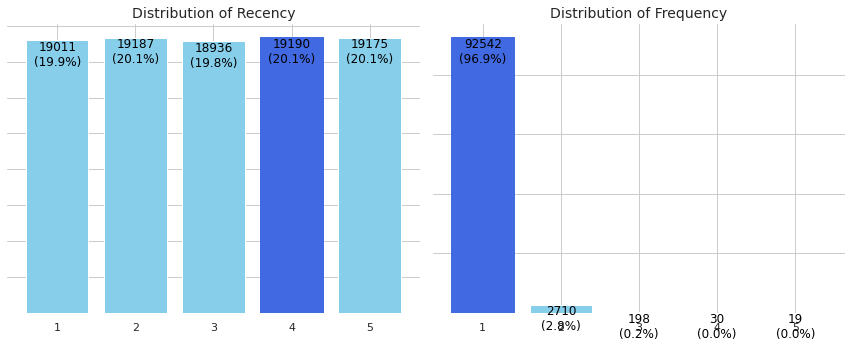

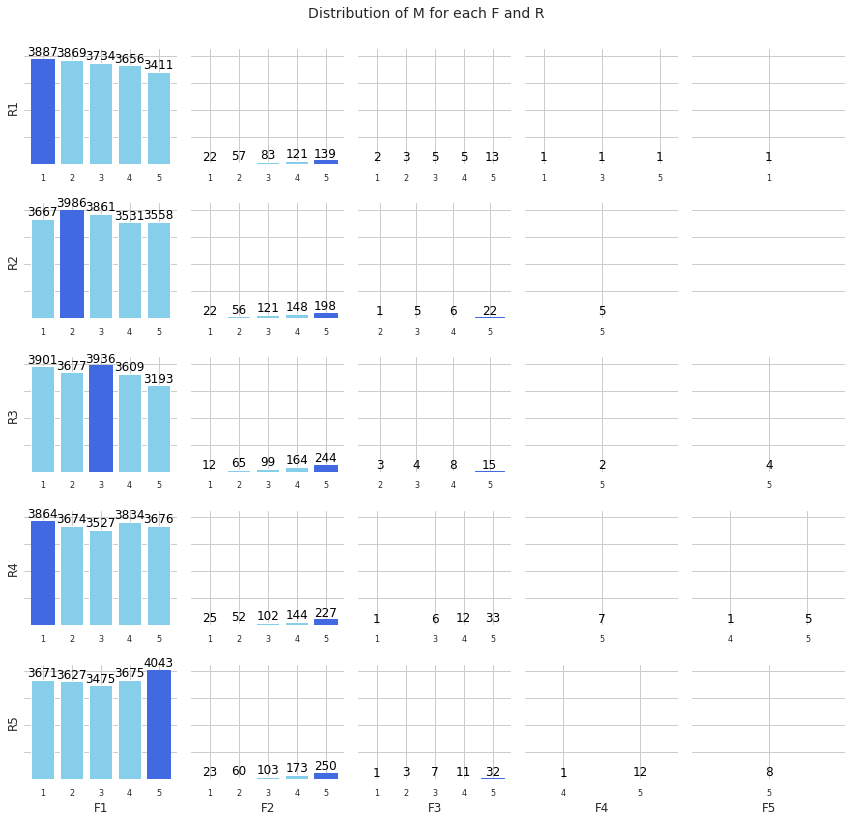

In [41]:
# Визуализация распределения клиентов по R и F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i, p in enumerate(['R', 'F']):
    parameters = {'R': 'Recency', 'F': 'Frequency'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='skyblue')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]), fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('royalblue')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({:.1f}%)'.format(int(value), value * 100 / y.sum()),
                ha='center', va='top', color='black')

plt.tight_layout()
plt.show()

# Визуализация распределения M для каждой F и R
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(12, 12))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='skyblue')
        if r == 5:
            if f == 3:
                ax.set_xlabel('F{}'.format(f), va='top', fontsize=12)
            else:
                ax.set_xlabel('F{}'.format(f), va='top', fontsize=12)
        if f == 1:
            if r == 3:
                ax.set_ylabel('R{}'.format(r), fontsize=12)
            else:
                ax.set_ylabel('R{}'.format(r), fontsize=12)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('royalblue')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='black')
fig.suptitle('Distribution of M for each F and R', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Проверим распределение по количеству заказов и выручке по месяцам и годам

In [45]:
#* Интересно посмотреть на кол заказов по годам и месяцам:
price_orders_1 = (
    order_and_costomer.merge(order_sum_price, on = 'order_id', how='left') \
    .groupby('order_purchase_mon_year', as_index=False) \
    .agg({'customer_id' : 'count', 'sum_price' : 'sum'}) \
    .rename(columns={'customer_id' : 'count_orders'})
)
price_orders_1.head()

,order_purchase_mon_year,count_orders,sum_price
0,2016-09,4,3616.20
1,2016-10,320,1329670.80
2,2016-12,1,95.05
3,2017-01,798,2808596.24
4,2017-02,1770,8395509.92


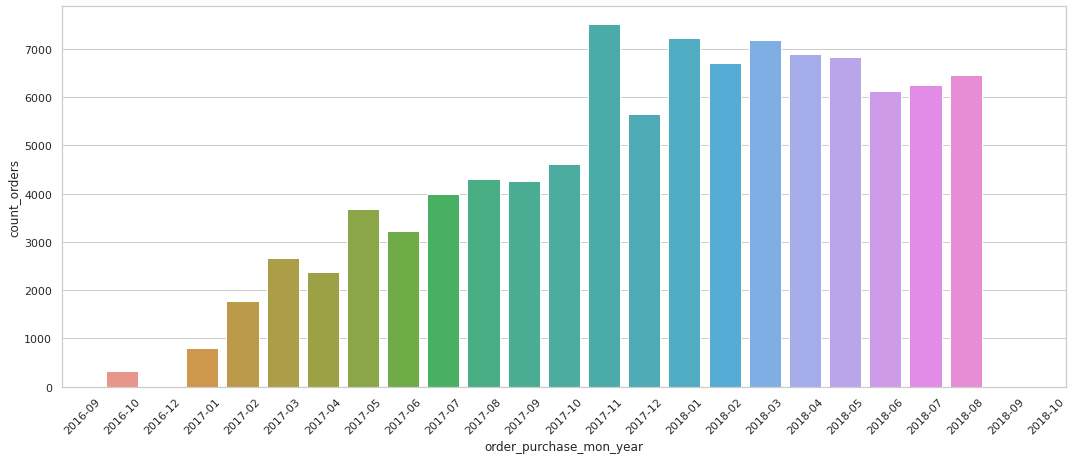

In [46]:
# Кол продаж
sns.barplot(data = price_orders_1, x='order_purchase_mon_year', y='count_orders')
plt.xticks(rotation=45)
plt.show()

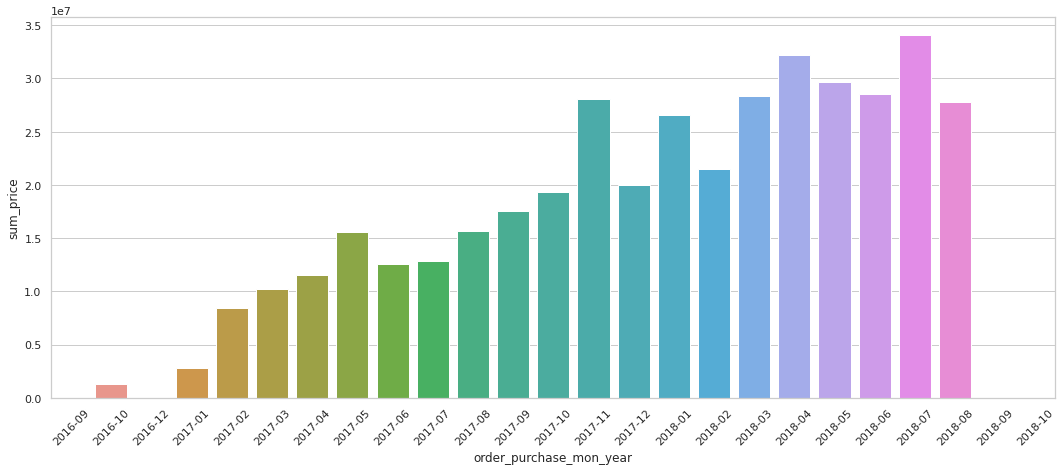

In [47]:
# Выручка по времени
sns.barplot(data = price_orders_1, x='order_purchase_mon_year', y='sum_price')
plt.xticks(rotation=45)
plt.show()

### Небольшое заключение:
- Количесество заказов не растет, но видим что выручка возрастает. На выходных наблюдается спад продаж.
- Retention низкий 0,65% пользователей совершают покупки на следующий месяц после первой покупки.
- 3.1% пользователей делают больше 1 покупки, что позволяет наращивать выручку.
- % отмен и недоставленных заказов 1.24% от всех заказов.